# Canny Edge Detection

In [85]:
import numpy as np
import cv2 
from scipy import misc
from scipy import ndimage
from matplotlib import pyplot as plt

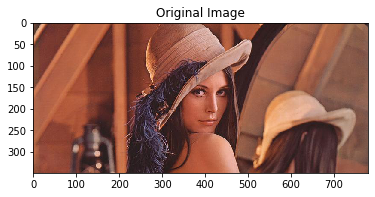

In [90]:
imgColor = cv2.imread('lenna.jpg')
plt.imshow(imgColor[...,::-1])
plt.title('Original Image')
plt.show()

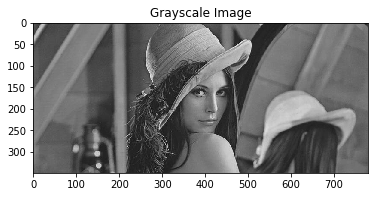

In [91]:
img = cv2.imread('lenna.jpg',0)
plt.imshow(img, cmap = plt.get_cmap('gray'))
plt.title('Grayscale Image')
plt.show()

## OpenCV Canny Method

In [147]:
edges = cv2.Canny(img,100,200,True)

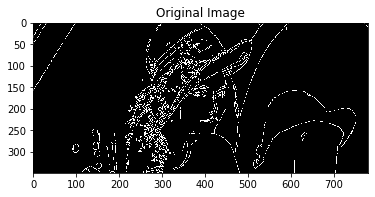

In [148]:
plt.imshow(edges, cmap = plt.get_cmap('gray'))
plt.title('Original Image')
plt.show()

# OpenCV Utilities

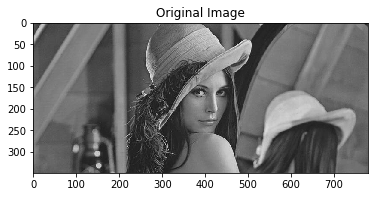

In [56]:
plt.imshow(img, cmap = plt.get_cmap('gray'))
plt.title('Original Image')
plt.show()

In [57]:
imgb= cv2.GaussianBlur(img,(5,5),0)

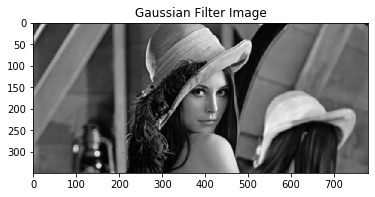

In [58]:
plt.imshow(imgb, cmap = plt.get_cmap('gray'))
plt.title('Gaussian Filter Image')
plt.show()

In [59]:
sobelx = cv2.Sobel(imgb,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(imgb,cv2.CV_64F,0,1,ksize=5)

In [60]:
abs_sobelx = cv2.convertScaleAbs(sobelx)
abs_sobely = cv2.convertScaleAbs(sobely)

grad = cv2.addWeighted(abs_sobelx, 0.001, abs_sobely, 0.001,0);


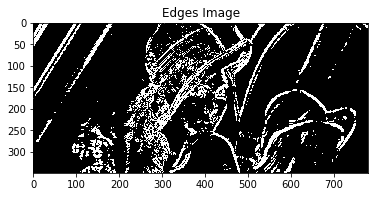

In [61]:
plt.imshow(grad, cmap = plt.get_cmap('gray'))
plt.title('Edges Image')
plt.show()

# Manual

### Theory
The Canny Edge detector was developed by John F. Canny in 1986. Also known to many as the optimal detector, Canny algorithm aims to satisfy three main criteria:
- **Low error rate**: Meaning a good detection of only existent edges.
- **Good localization**: The distance between edge pixels detected and real edge pixels have to be minimized.
- **Minimal response**: Only one detector response per edge

### Implementation

#### 1.GrayScale Conversion

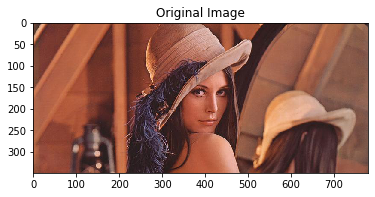

In [151]:
imgColor = cv2.imread('lenna.jpg')
plt.imshow(imgColor[...,::-1])
plt.title('Original Image')
plt.show()

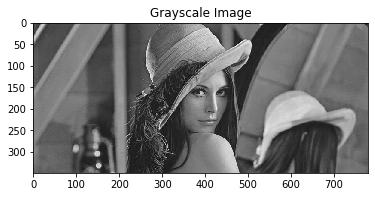

In [190]:
img = cv2.cvtColor(imgColor, cv2.COLOR_BGR2GRAY)
# Normalize image
img = img/np.max(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
plt.title('Grayscale Image')
plt.show()

#### 2.Noise reduction
To filter out any noise a **Gaussian Filter** is applied to the image. 
The blur removes some of the noise before further processing the image. 


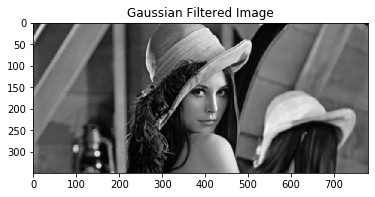

In [191]:
imgb= cv2.GaussianBlur(img,(5,5),0)
plt.imshow(imgb, cmap = plt.get_cmap('gray'))
plt.title('Gaussian Filtered Image')
plt.show()

#### 3.Intensity Gradients
Find the intensity gradient of the image. For this, we follow a procedure analogous to Sobel:

Apply a pair of convolution masks

$$\begin{equation}
 \mathbf{G}_x = 
 \begin{bmatrix} 
 -1 & 0 & 1 \\ 
 -1 & 0 & 1 \\ 
 -1 & 0 & 1 
 \end{bmatrix}
Img
\end{equation}$$

$$\begin{equation}
\mathbf{G}_y = 
 \begin{bmatrix} 
 -1 & -2 & -1 \\ 
 0 & 0 & 0 \\ 
 -1 & 2 & 1 
 \end{bmatrix}
Img
\end{equation}$$

In [192]:
Gtx = np.array([[-1,0,1], [-2,0,2],  [-1,0,1]])
Gx = ndimage.convolve(imgb, Gtx)
Gx = Gx/np.max(Gx)

Gty = np.array([[-1,-2,-1], [0,0,0], [1,2,1]])
Gy = ndimage.convolve(imgb, Gty)
Gy = Gy/np.max(Gy)

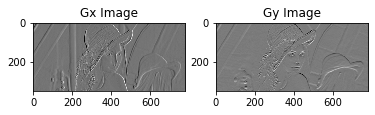

In [193]:
plt.subplot(121)
plt.imshow(Gx, cmap = plt.get_cmap('gray'))
plt.title('Gx Image')
plt.subplot(122)
plt.imshow(Gy, cmap = plt.get_cmap('gray'))
plt.title('Gy Image')
plt.show()

Find the gradient magnitude and direction

$$
|G| = \sqrt{\mathbf{G}_x ^2 + \mathbf{G}_y ^2 }
$$

$$
\angle{G} = \arctan{\left(\frac{\mathbf{G}_y}{  \mathbf{G}_x}  \right)}
$$

In [194]:
Gabs = np.hypot(Gx,Gy)
Gabs = Gabs/np.max(Gabs)

Gangle = np.degrees(np.arctan2(Gy,Gx))

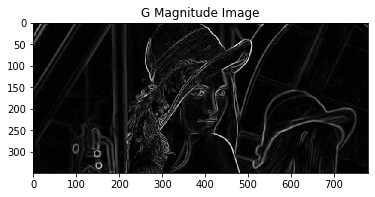

In [195]:
plt.imshow(Gabs, cmap = plt.get_cmap('gray'))
plt.title('G Magnitude Image')
plt.show()

### 4.Non-maximum suppression
This removes pixels that are not considered to be part of an edge. Hence, only thin lines (candidate edges) will remain.

Non maximum suppression works by finding the pixel with the maximum value in an edge. In the above image, it occurs when pixel q has an intensity that is larger than both p and r where pixels p and r are the pixels in the gradient direction of q. If this condition is true, then we keep the pixel, otherwise we set the pixel to zero (make it a black pixel).

In [196]:
NMS = np.zeros(Gabs.shape)
    
for i in range(1, int(Gabs.shape[0]) - 1):
    for j in range(1, int(Gabs.shape[1]) - 1):
        if((Gangle[i,j] >= 0 and Gangle[i,j] <= 45) or (Gangle[i,j] < -135 and Gangle[i,j] >= -180)):
            yBot = np.array([Gabs[i,j+1], Gabs[i+1,j+1]])
            yTop = np.array([Gabs[i,j-1], Gabs[i-1,j-1]])
            x_est = np.absolute(Gy[i,j]/Gabs[i,j])
            if (Gabs[i,j] >= ((yBot[1]-yBot[0])*x_est+yBot[0]) and Gabs[i,j] >= ((yTop[1]-yTop[0])*x_est+yTop[0])):
                NMS[i,j] = Gabs[i,j]
            else:
                NMS[i,j] = 0
        if((Gangle[i,j] > 45 and Gangle[i,j] <= 90) or (Gangle[i,j] < -90 and Gangle[i,j] >= -135)):
            yBot = np.array([Gabs[i+1,j] ,Gabs[i+1,j+1]])
            yTop = np.array([Gabs[i-1,j] ,Gabs[i-1,j-1]])
            x_est = np.absolute(Gx[i,j]/Gabs[i,j])
            if (Gabs[i,j] >= ((yBot[1]-yBot[0])*x_est+yBot[0]) and Gabs[i,j] >= ((yTop[1]-yTop[0])*x_est+yTop[0])):
                NMS[i,j] = Gabs[i,j]
            else:
                NMS[i,j] = 0
        if((Gangle[i,j] > 90 and Gangle[i,j] <= 135) or (Gangle[i,j] < -45 and Gangle[i,j] >= -90)):
            yBot = np.array([Gabs[i+1,j] ,Gabs[i+1,j-1]])
            yTop = np.array([Gabs[i-1,j] ,Gabs[i-1,j+1]])
            x_est = np.absolute(Gx[i,j]/Gabs[i,j])
            if (Gabs[i,j] >= ((yBot[1]-yBot[0])*x_est+yBot[0]) and Gabs[i,j] >= ((yTop[1]-yTop[0])*x_est+yTop[0])):
                NMS[i,j] = Gabs[i,j]
            else:
                NMS[i,j] = 0
        if((Gangle[i,j] > 135 and Gangle[i,j] <= 180) or (Gangle[i,j] < 0 and Gangle[i,j] >= -45)):
            yBot = np.array([Gabs[i,j-1] ,Gabs[i+1,j-1]])
            yTop = np.array([Gabs[i,j+1] ,Gabs[i-1,j+1]])
            x_est = np.absolute(Gy[i,j]/Gabs[i,j])
            if (Gabs[i,j] >= ((yBot[1]-yBot[0])*x_est+yBot[0]) and Gabs[i,j] >= ((yTop[1]-yTop[0])*x_est+yTop[0])):
                NMS[i,j] = Gabs[i,j]
            else:
                NMS[i,j] = 0
    

C:\Users\herreral\Miniconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


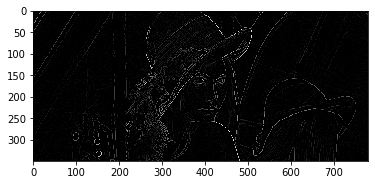

In [197]:
plt.imshow(NMS, cmap = plt.get_cmap('gray'))
plt.show()

#### 5.DOUBLE THRESHOLDING

Canny does use two thresholds (upper and lower):

1. If a pixel gradient is higher than the upper threshold, the pixel is accepted as an edge
2. If a pixel gradient value is below the lower threshold, then it is rejected.
3. If the pixel gradient is between the two thresholds, then it will be accepted only if it is connected to a pixel that is above the upper threshold.

Note: _Canny recommended a upper:lower ratio between 2:1 and 3:1._

In [198]:
highThresholdRatio = 0.2  
lowThresholdRatio = 0.15 
GSup = np.copy(NMS)
h = int(GSup.shape[0])
w = int(GSup.shape[1])
highThreshold = np.max(GSup) * highThresholdRatio
lowThreshold = highThreshold * lowThresholdRatio    
x = 0.1
oldx=0

# The while loop is used so that the loop will keep executing till the number of strong edges do not change, i.e all weak edges connected to strong edges have been found
while(oldx != x):
    oldx = x
    for i in range(1,h-1):
        for j in range(1,w-1):
            if(GSup[i,j] > highThreshold):
                GSup[i,j] = 1
            elif(GSup[i,j] < lowThreshold):
                GSup[i,j] = 0
            else:
                if((GSup[i-1,j-1] > highThreshold) or 
                    (GSup[i-1,j] > highThreshold) or
                    (GSup[i-1,j+1] > highThreshold) or
                    (GSup[i,j-1] > highThreshold) or
                    (GSup[i,j+1] > highThreshold) or
                    (GSup[i+1,j-1] > highThreshold) or
                    (GSup[i+1,j] > highThreshold) or
                    (GSup[i+1,j+1] > highThreshold)):
                    GSup[i,j] = 1
    x = np.sum(GSup == 1)

GSup = (GSup == 1) * GSup

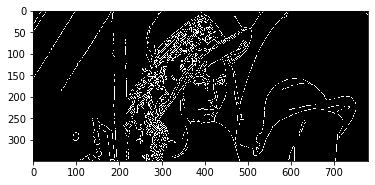

In [199]:
plt.imshow(GSup, cmap = plt.get_cmap('gray'))
plt.show()